In [2]:
##########################################
# Create custom linktable
# June 2020
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

Enter your WRDS username [ruben]:alfgarar
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [31]:
###################################################################
### Get both CRSP and Compustat data and merge on cusip number
###################################################################

link_table = conn.raw_sql("""
                      select distinct a.permno, c.gvkey, c.iid, namedt, nameendt
                      from crsp.msf as a,
                      crsp.msenames as b,
                      comp.security as c
                      where a.date between '01/01/1970' and '06/01/2020'
                      and a.permno=b.permno
                      and a.date between namedt and nameendt
                      and b.ncusip=substr(c.cusip,1,8)
                      and c.excntry='USA'
                      and b.shrcd between 9.9 and 11.9
                      """) 

In [33]:
print('Shape:',link_table.shape)
### Make sure the date is within the valid range for the name
# link_table = link_table[link_table['date']>=link_table['namedt']]
# link_table = link_table[link_table['date']<=link_table['nameendt']]

# Convert date to year
#link_table['year'] = pd.DatetimeIndex(link_table['date']).year

# Get rid of duplicates (months)
clean_table = link_table[['permno','gvkey','iid','namedt','nameendt']].drop_duplicates()

#### SOME TESTING
# clean_table.sort_values(by='comnam')
# clean_table.apply(lambda x: len(x.unique()))
# pd.pivot_table(clean_table,values='ticker',index='permno', aggfunc=pd.Series.nunique).sort_values(by='ticker')
# clean_table[clean_table['permno']==81190]

clean_table['gvkey_iid']=clean_table['gvkey']+'_'+clean_table['iid']
final_link = clean_table[['namedt','nameendt','permno','gvkey_iid']]
final_link.sort_values(by='nameendt')
# final_link.apply(lambda x: len(x.unique()))
# pd.pivot_table(final_link,values='gvkey_iid',index='permno', aggfunc=pd.Series.nunique).sort_values(by='gvkey_iid')
# clean_table[clean_table['permno']==90031]

Shape: (44881, 5)


,namedt,nameendt,permno,gvkey_iid
14126,1969-03-24,1970-02-26,44759.0,181780_01
4387,1968-01-02,1970-03-02,13573.0,266101_01
12340,1968-01-02,1970-03-13,37444.0,010652_01
8276,1969-11-18,1970-03-17,20714.0,002301_01
15307,1969-07-08,1970-03-20,48688.0,002739_01
...,...,...,...,...
4746,2019-11-21,2019-12-31,14045.0,024351_01
4747,2013-07-25,2019-12-31,14046.0,018161_01
30363,2017-12-12,2019-12-31,80912.0,003806_01
4807,2013-09-26,2019-12-31,14145.0,018564_01


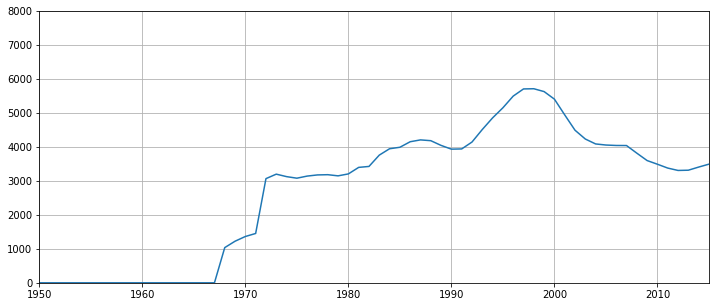

In [46]:
stock_count = final_link
stock_count['Byear'] = pd.DatetimeIndex(final_link['namedt']).year
stock_count['Eyear'] = pd.DatetimeIndex(final_link['nameendt']).year
stock_count.head()
years = [i for i in range(1950,2020)]
counts = []
for year in years:
    df = stock_count[stock_count['Byear']<=year]
    df = df[df['Eyear']>=year]
    counts.append(len(df['permno'].unique()))

plt.figure(figsize=(12,5))
plt.axis([1950,2015,0,8000])
plt.plot(years, counts)
plt.grid()